plan-track

In [ ]:
from trainer.trainer import CWPTT
import matplotlib.pyplot as plt
n_debris = 3 # number of debris
trainer, _ = CWPTT(n_debris, "cuda", load="../model/planTrack3.ptd") # `planTrackTrainer` instance

Output()

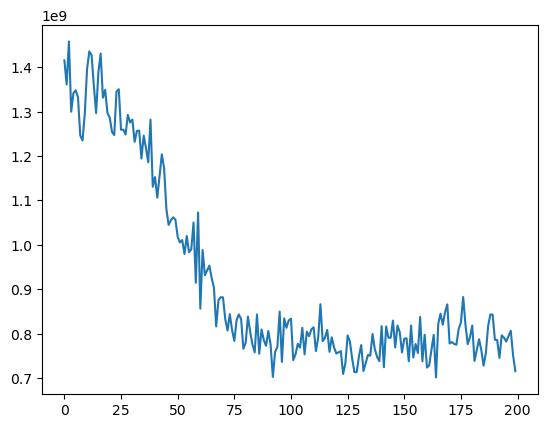

In [2]:
ll = trainer.trainTracker(1200) # train tracker solely, mode-based
# trainer.agent.save(f"../model/planTrack{n_debris}.ptd")
plt.close("all")
plt.plot(ll) # loss
plt.show()

In [ ]:
al, cl, tr = trainer.trainPlanner(episode=1000, epoch=10) # train planner and critic, mode-free
trainer.agent.save(f"../model/planTrack{n_debris}.ptd")
plt.close("all")
plt.plot(tr) # total reward
plt.show()

In [8]:
results = trainer.trainUnity(3600, epoch=1, batch_size=128) # train all model together, to be completed

Output()

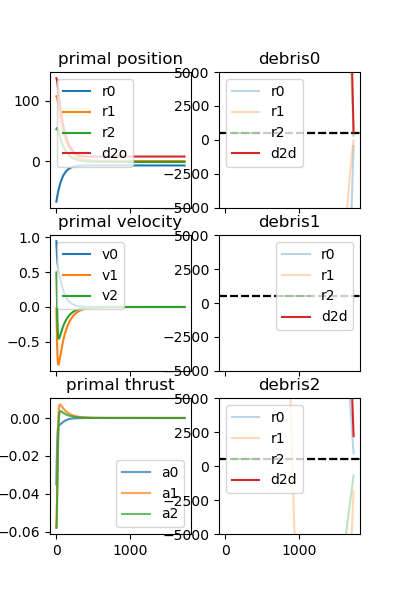

In [3]:
from plotting.analyze import *
%matplotlib widget
horizon = 3600
d, stage = trainer.test(horizon, "static") # test agent
plt.close('all')
n_debris = trainer.mainProp.n_debris
fig, _ = historyFile(d, agent=None, stage=stage, n_debris=n_debris,) # visualization

In [5]:
x = d["states"][:,:6*(n_debris+1)]

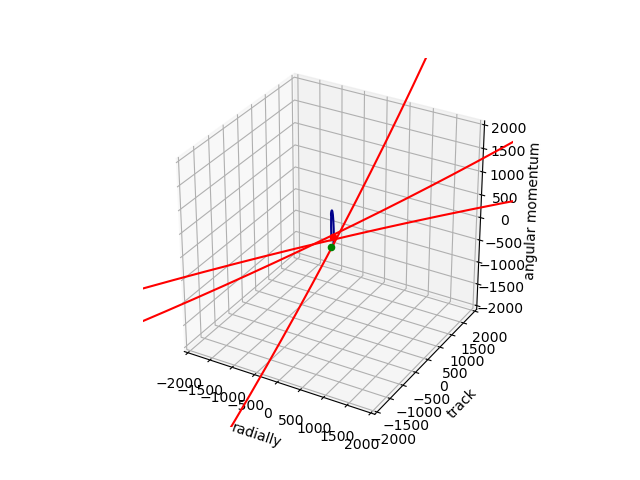

In [8]:
from plotting.trajplot import mulDeTrajPlot
plt.close('all')
ax, objs = mulDeTrajPlot(x)
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from plotting import trajplot
import math

def foo(x:np.ndarray,
        box_lim=2000,
        step=10,
        interval=5
        ):
    fig = plt.figure()
    ax = fig.add_axes(rect=[0, 0, 1, 1],
                      projection='3d',
                      xlim=(-box_lim, box_lim),
                      ylim=(-box_lim, box_lim),
                      zlim=(-box_lim, box_lim)
                     )
    ax.set_xlabel("radially")
    ax.set_ylabel("track")
    ax.set_zlabel("angular momentum")
    ax.set_aspect("equal")
    total = x.shape[0]
    x = x.reshape([total, -1, 6])

    n_frame = math.ceil(total/step)

    ax, objs = trajplot.mulDeTrajPlot(x, ax=ax, cur_pos=True)
    trajs = objs["trajs"]
    curs = objs["curs"]
    n_obj = len(trajs)

    colors = ["blue"] + ["red" for _ in range(n_obj-1)]

    def animate(frame_number):
        n = frame_number*step
        for i in range(n_obj):
            trajs[i].remove()
            trajs[i] = ax.plot3D(x[:n,i,0],x[:n,i,1],x[:n,i,2], color=colors[i])[0]
            curs[i].remove()
            curs[i] = ax.scatter3D(x[n,i,0],x[n,i,1],x[n,i,2], color=colors[i])
            

    ani = animation.FuncAnimation(fig, animate, frames=n_frame, interval=interval)

    return ani

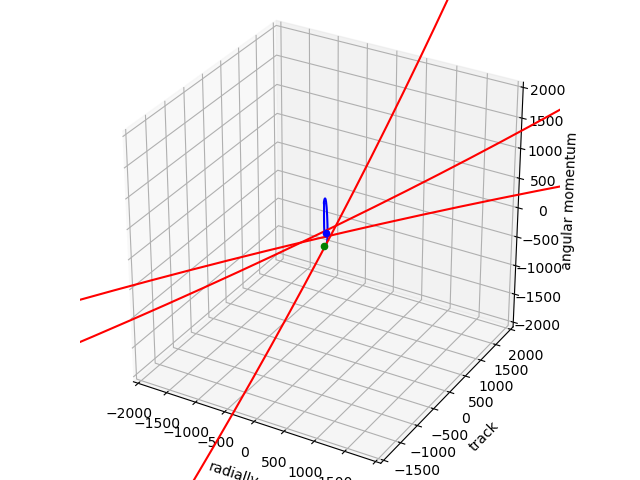

In [20]:
ani = foo(x, interval=50)
ani.save('animation.gif', writer='ffmpeg')

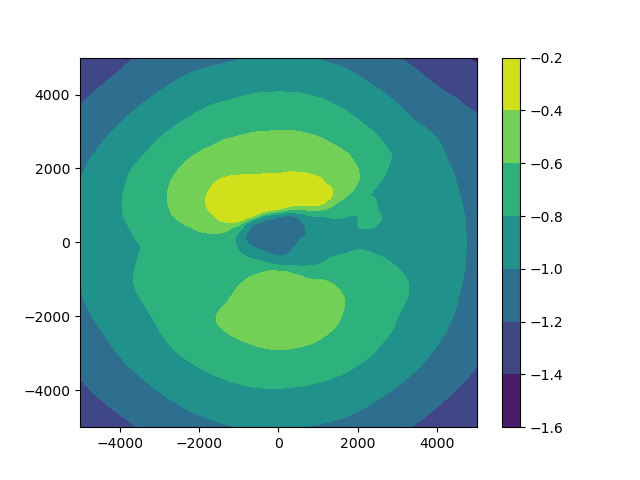

In [322]:
import numpy as np
from plotting import analyze
import torch
s = trainer.mainProp.randomInitStates(1)
o = trainer.mainProp.getObss(s)
o_a = np.hstack((o.flatten(), np.zeros(trainer.agent.control_dim)))

n_f = trainer.agent.critic.n_feature
axis = np.array([0,2])
axis.sort()
dims = n_f-(3-axis)
o_a_ = np.delete(o_a, dims)

plt.close("all")
analyze.criticContour(trainer.agent, span=(-5000,5000), dims=dims, step=101, singles=o_a_) # contour plot of critic in selected dims

target = trainer.agent.planner(torch.from_numpy(o).float().to(trainer.agent.device))
target = target.detach().cpu().numpy().flatten()
_ = plt.scatter(target[axis[0]], target[axis[1]], c="r") # planner's output

模仿学习

In [1]:
from env.propagators.hierarchicalPropagator import impulsePropagator
import torch
import numpy as np
import matplotlib.pyplot as plt

impulse_bound = 0.1
prop = impulsePropagator(3, device="cuda", h1_step=30, h2_step=120, 
                         impulse_bound=impulse_bound, safe_dist=2000.)
batch_size = 320
max_loop = 15
impulse_num = 20

from agent.net import boundedFcNet, boundedLSTM
upper_bounds = [ impulse_bound]*3
lower_bounds = [-impulse_bound]*3
actor = boundedFcNet(prop.obs_dim, 3, [512]*4, 
                     upper_bounds=upper_bounds, 
                     lower_bounds=lower_bounds).to("cuda")
# actor = boundedLSTM(prop.obs_dim, 3, 128, 12, [512]*3, 
#                     upper_bounds=upper_bounds, 
#                     lower_bounds=lower_bounds).to("cuda")
opt1 = torch.optim.Adam(actor.parameters(), lr=0.001)

In [ ]:
# make data
from data.loader import npzLoader
feature = []
label = []
for epoch in range(40):
    s0 = prop.randomInitStates(batch_size)
    imp, best_i, rewards = prop.best_impulses(s0, max_loop=max_loop, impulse_num=impulse_num)
    best_imp = torch.zeros((imp.shape[0], imp.shape[2], imp.shape[3]), device=imp.device)
    for i in range(batch_size):
        best_imp[i,...] = imp[i,best_i[i],...]
    best_imp_ = best_imp.transpose(0,1)

    td1, td2, _ = prop.impulses_test(s0, best_imp)

    feature.append(td1["obss"].detach().cpu())
    label.append(best_imp_.detach().cpu())
feature = torch.cat(feature, dim=1)
label = torch.cat(label, dim=1)
loader = npzLoader.make("../model/sv/data.npz", feature=feature, label=label)

In [5]:
from data.loader import npzLoader
i = 1
loader = npzLoader(f"../model/sv/data{i}.npz")
feature, label = loader.torch(actor.device)

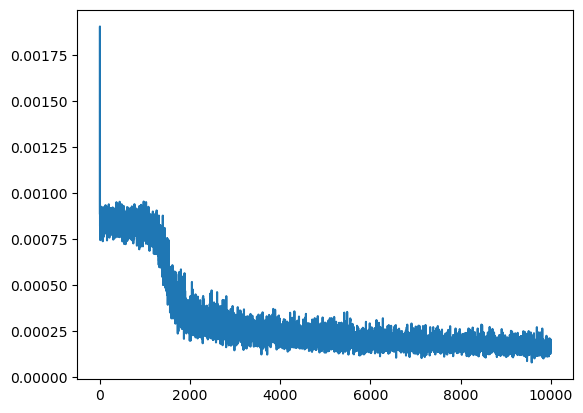

In [3]:
loss_list = []
total = feature.shape[1]
mini_batch = 64
epoch = 10000
for j in range(epoch):
    idx = np.random.choice(total, mini_batch, replace=False)
    obss = feature[:, idx].to(actor.device)
    out = actor(obss)
    loss = torch.nn.functional.mse_loss(label[:,idx].to(actor.device), out, reduction='mean')
    opt1.zero_grad()
    loss.backward()
    opt1.step()
    loss_list.append(loss.item())
plt.plot(loss_list[:])
plt.show()

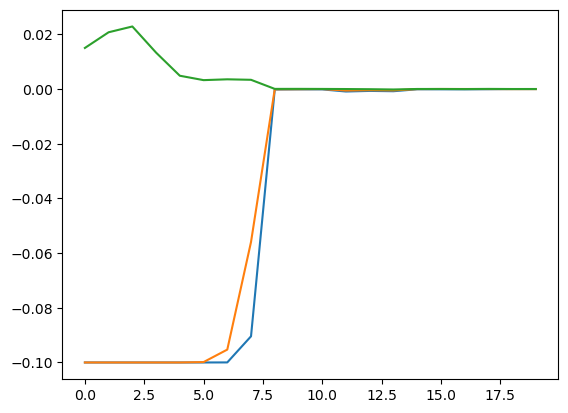

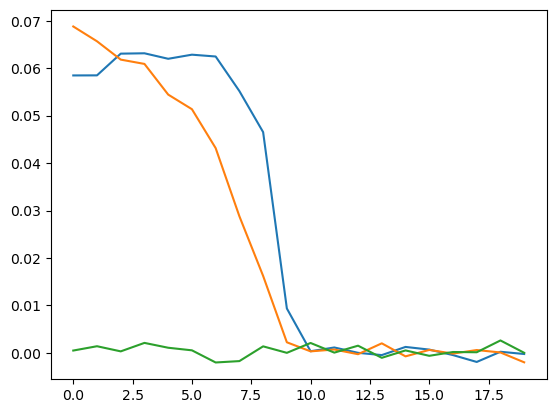

In [58]:
idx = np.random.randint(0, feature.shape[1])

obss = feature[:,idx].to(actor.device)
out = actor(obss)

# check gradient vanishing
# opt1.zero_grad()
# loss = torch.abs(out).mean()
# loss.backward()
# g = [p.grad for p in actor.parameters()]
# print(g)

plt.plot(out[:].detach().cpu().numpy())
plt.show()
plt.plot(label[:,idx].detach().cpu().numpy())
plt.show()

In [3]:
s0 = prop.randomInitStates(batch_size)
imp, best_i, rewards = prop.best_impulses(s0, max_loop=max_loop, impulse_num=impulse_num)
best_imp = torch.zeros((imp.shape[0], imp.shape[2], imp.shape[3]), device=imp.device)
for i in range(batch_size):
    best_imp[i,...] = imp[i,best_i[i],...]
td1_best, td2_best, rewards_best = prop.impulses_test(s0, best_imp)
td1, td2, rewards = prop.impulses_test_actor(s0, actor, impulse_num=impulse_num)

print(rewards_best.mean().item(), rewards.mean().item())
print(rewards_best.min().item(),  rewards.min().item())

Output()

d:\code\workshop\genetic tree search\env\propagators\hierarchicalPropagator.py:693: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _impulses = torch.tensor(_impulses, requires_grad=True, device=self.device)


-0.02392573282122612 -0.02207765355706215
-0.07259679585695267 -0.06910334527492523


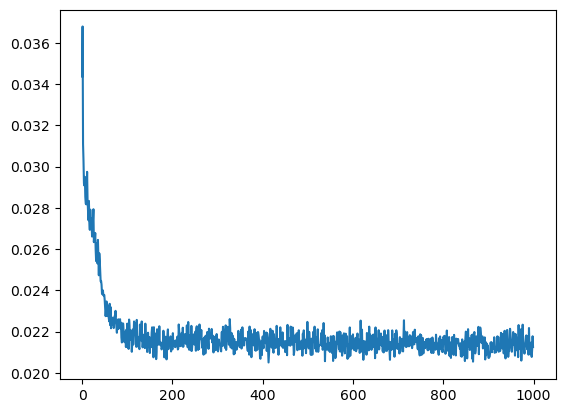

In [2]:
L = []
for _ in range(1000):
    td1, td2, rewards = prop.actor_opt(actor, batch_size=batch_size, impulse_num=impulse_num)
    loss = -rewards.mean()
    opt1.zero_grad()
    loss.backward()
    opt1.step()
    L.append(loss.item())
plt.plot(L)